In [42]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [44]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3 # RGB Channels
EPOCHS=50

## Import data into tensorflow dataset object
TensorFlow’s image_size argument resizes the image while preserving the aspect ratio (width to height ratio).

Using image_dataset_from_directory api to load all images in tensorflow dataset:

In [46]:
# Load training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "BrainTumor/Training",  # Path to the training folder
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5712 files belonging to 4 classes.


In [110]:
# Load testing dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "BrainTumor/testing",  # Path to the testing folder
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1311 files belonging to 4 classes.


In [50]:
print("Train Class Names:", train_dataset.class_names)
print("Test Class Names:", test_dataset.class_names)

Train Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Test Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [52]:
class_names = train_dataset.class_names

In [54]:
for image_batch, labels_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 3 1 1 1 0 0 3 1 3 2 1 3 2 2 1 1 2 1 0 2 2 3 3 2 3 1 3 1 1 0 3]


Each element in the dataset is a tuple. 

First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

## Visualization of datasets

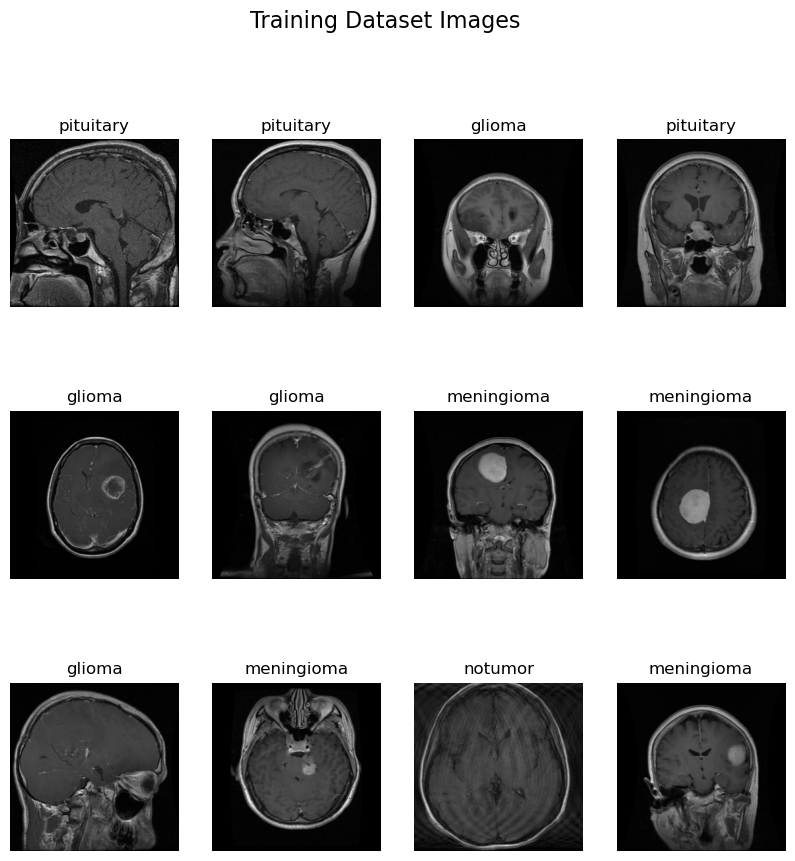

In [56]:
# Plot images from the train dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_dataset.take(1):  # Display first batch of train dataset
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])  # Use class_names from the train dataset
        plt.axis("off")
plt.suptitle("Training Dataset Images", fontsize=16)
plt.show()

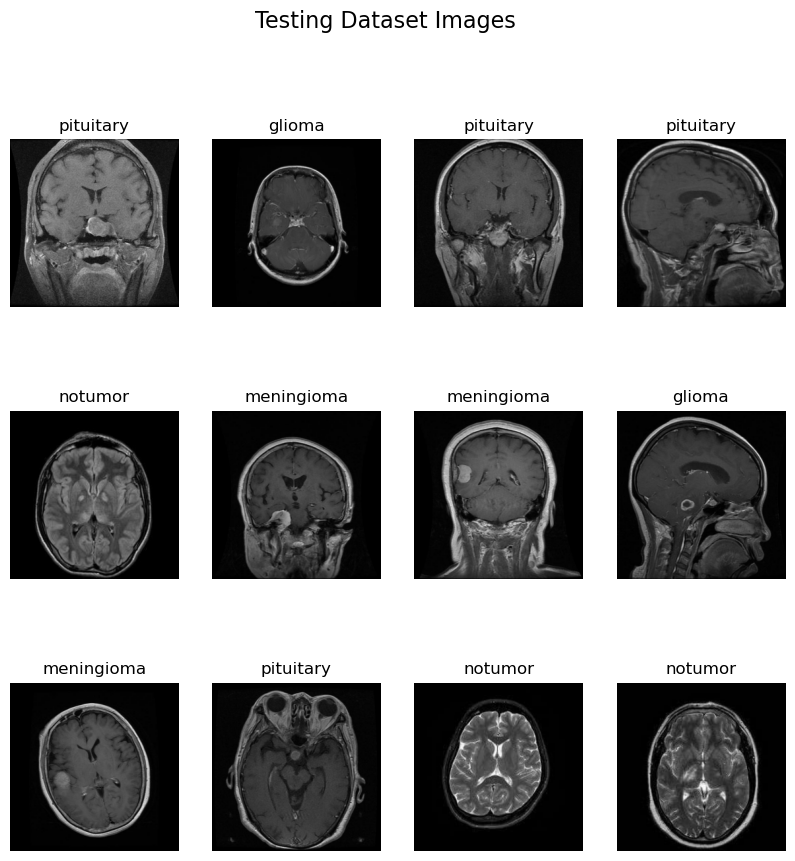

In [58]:
# Plot images from the test dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in test_dataset.take(1):  # Display first batch of test dataset
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])  # Use class_names from the test dataset
        plt.axis("off")
plt.suptitle("Testing Dataset Images", fontsize=16)
plt.show()

## Splitting test dataset into test and validation datasets

In [112]:
train_ds = train_dataset
len(train_ds) # Number of batches

179

In [114]:
len(test_dataset) # Number of batches

41

In [116]:
val_size = 0.5  # Half of test_dataset
len(test_dataset)*val_size

20.5

In [120]:
val_ds = test_dataset.take(20)
len(val_ds)

20

In [122]:
test_ds = test_dataset.skip(20)
len(test_ds)

21

In [124]:
def get_test_dataset_partitions_tf(ds, test_split=0.5, val_split=0.5, shuffle=True, shuffle_size=10000):
    assert (test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    val_size = int(val_split * ds_size)
    
    val_ds = ds.take(val_size)
    test_ds = ds.skip(val_size)
    
    return val_ds, test_ds

In [128]:
val_ds, test_ds = get_test_dataset_partitions_tf(test_dataset)

In [130]:
len(val_ds)

20

In [132]:
len(test_ds)

21

In [134]:
len(train_ds)

179

## Cache, Shuffle, and Prefetch the Dataset

In [137]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization

In [151]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])

### Data Augmentation

In [155]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [157]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### CNN Model Architecture

In [229]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    #layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [231]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,388 (3.42 MB)

 Trainable params: 896,388 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model
Using adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [233]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Training the Model

In [235]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 375ms/step - accuracy: 0.4540 - loss: 1.1412 - val_accuracy: 0.6714 - val_loss: 0.9012
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 68s 379ms/step - accuracy: 0.6846 - loss: 0.7959 - val_accuracy: 0.6933 - val_loss: 0.7609
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 373ms/step - accuracy: 0.7253 - loss: 0.6972 - val_accuracy: 0.7355 - val_loss: 0.6386
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 374ms/step - accuracy: 0.7656 - loss: 0.6215 - val_accuracy: 0.7684 - val_loss: 0.6117
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 373ms/step - accuracy: 0.7750 - loss: 0.5866 - val_accuracy: 0.7653 - val_loss: 0.5910
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 374ms/step - accuracy: 0.7881 - loss: 0.5576 - val_accuracy: 0.7543 - val_loss: 0.5829
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 68s 378ms/step - accuracy: 0.8058 - loss: 0.5098 - val_accuracy: 0.8200 - val_loss: 0.4404
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 372ms/step - accuracy: 0.8364 - loss: 0

In [237]:
scores = model.evaluate(test_ds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9637 - loss: 0.1083


## Plotting the Accuracy and Loss Curves

In [244]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

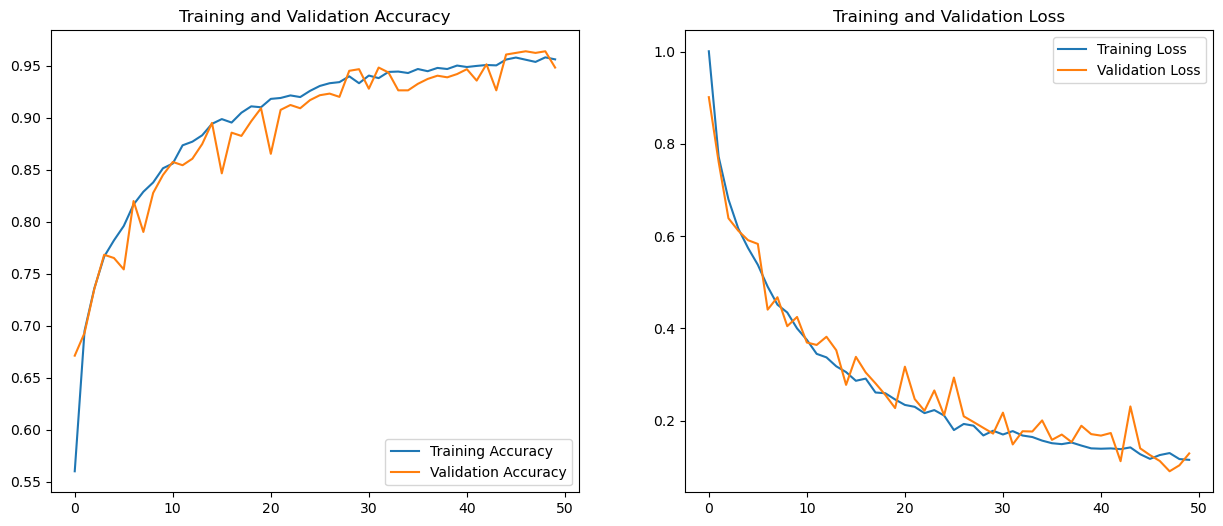

In [256]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predictions

Actual label: glioma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predicted label: glioma


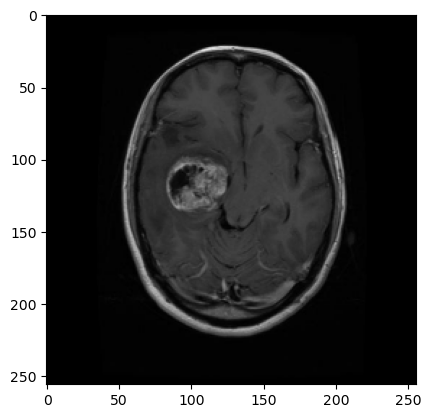

In [271]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [265]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


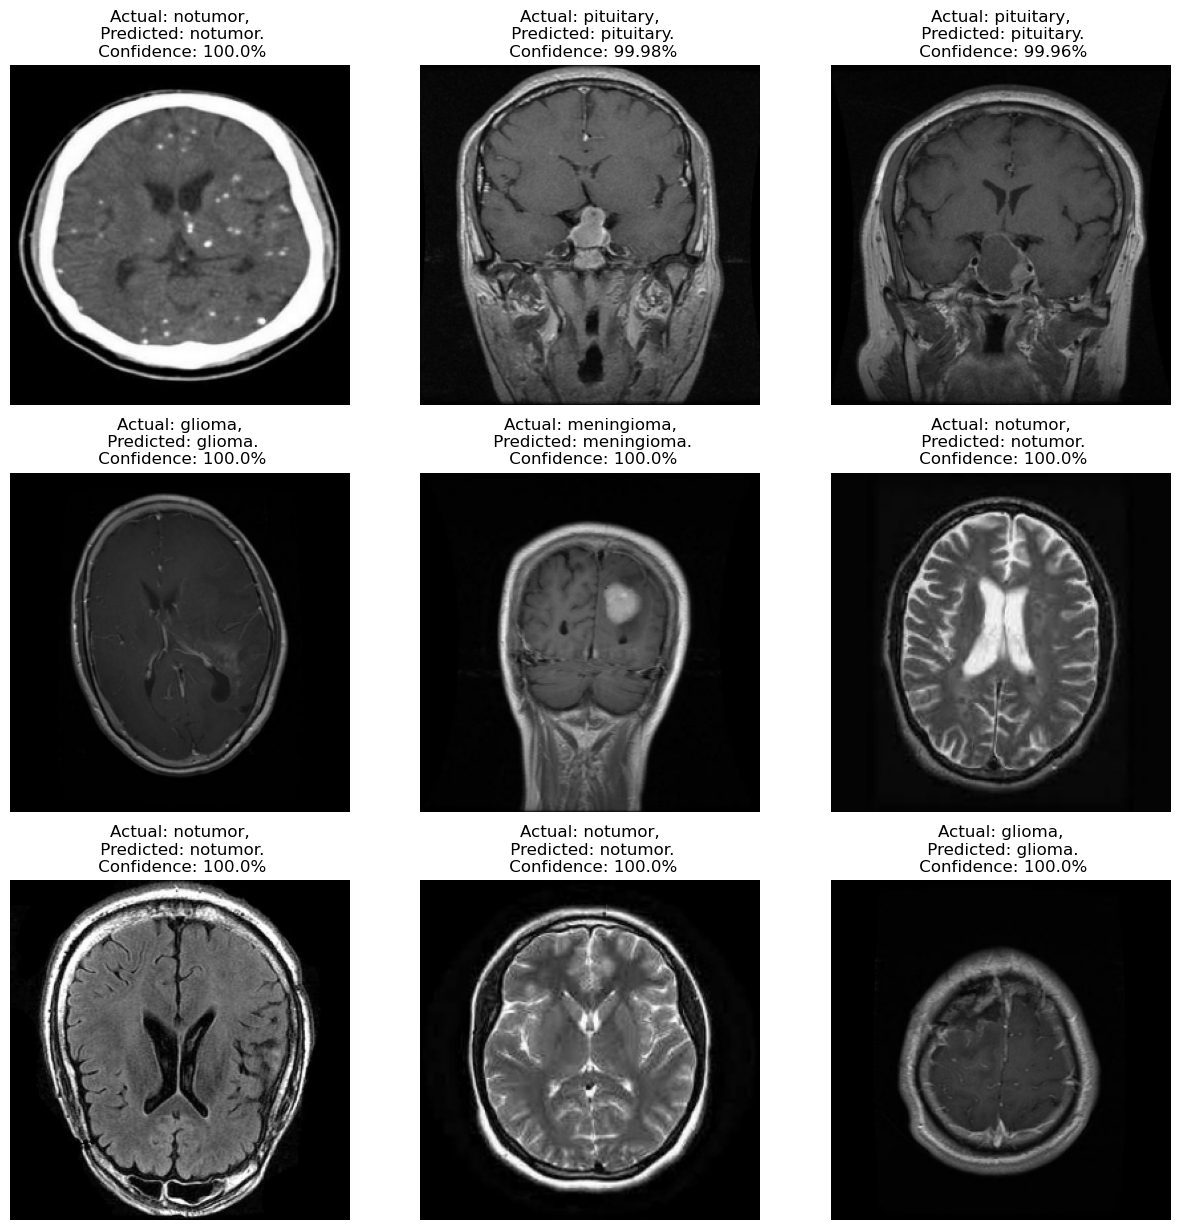

In [267]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model

In [281]:
import os
model_version = max([int(i) for i in os.listdir("Models") + [0]])+1 # Get the next version number

# Create a new folder for the current model version
model_version_folder = f"Models/{model_version}"
os.makedirs(model_version_folder)

model.save(f"{model_version_folder}/brain_tumor_model.keras") 